In [1]:
## loading package 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import pylab
import seaborn as sns 
from sklearn.metrics.pairwise import cosine_similarity
from statannot import add_stat_annotation
import matplotlib as mpl
from scipy import stats, cluster
import glob
import re
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats import multitest
from matplotlib.gridspec import GridSpec

from matplotlib_venn import venn2, venn3
from matplotlib import pyplot as plt

import warnings 
warnings.simplefilter('ignore')

## load_large_dataFrame
def load_large_dataFrame(input_file, sep=",", header=0, index_col=0, chunksize=100000, compressed=False):
    if compressed:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col, compression='gzip')
    else:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col)
    dfList=[]
    for df in TextFileReader:
        dfList.append(df)
    final_df = pd.concat(dfList,sort=False)
    return final_df

## 1. Nucleotide Heterogeneity by Rsquare

### 1.1 load mutant counts and coverage matrix (1nt)

In [2]:
## Retrieve mutant matrix
b1_h9_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.h9.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_h9_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.h9.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day0_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day0.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day0_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day0.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day1_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day1.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day1_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day1.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day7_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day7.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day7_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day7.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])

h9_mutant = pd.concat([b1_h9_mutant, b2_h9_mutant], axis=1)
day0_mutant = pd.concat([b1_day0_mutant, b2_day0_mutant], axis=1)
day1_mutant = pd.concat([b1_day1_mutant, b2_day1_mutant], axis=1)
day7_mutant = pd.concat([b1_day7_mutant, b2_day7_mutant], axis=1)

h9_mutant = h9_mutant.loc[h9_mutant.isnull().sum(axis=1) < h9_mutant.columns.size*0.5]
day0_mutant = day0_mutant.loc[day0_mutant.isnull().sum(axis=1) < day0_mutant.columns.size*0.5]
day1_mutant = day1_mutant.loc[day1_mutant.isnull().sum(axis=1) < day1_mutant.columns.size*0.5]
day7_mutant = day7_mutant.loc[day7_mutant.isnull().sum(axis=1) < day7_mutant.columns.size*0.5]

### add rRNAs
rRNA_df = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/all_cells.mutant.rRNA.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
def add_rRNA_data(rRNA_df, df):
    df = df.loc[~df.index.get_level_values('gene').isin(['human_small', 'human_large'])]
    df = pd.concat([df, rRNA_df], join="inner")
    return df
h9_mutant = add_rRNA_data(rRNA_df, h9_mutant)
day0_mutant = add_rRNA_data(rRNA_df, day0_mutant)
day1_mutant = add_rRNA_data(rRNA_df, day1_mutant)
day7_mutant = add_rRNA_data(rRNA_df, day7_mutant)

mutant_df = pd.concat([h9_mutant, day0_mutant, day1_mutant, day7_mutant], axis=1)
mutant_df

id          RHE1534 RHE1540 RHE1546 RHE1552 RHE1558 RHE1564 RHE1570 RHE1576  \
batch       batch_1 batch_1 batch_1 batch_1 batch_1 batch_1 batch_1 batch_1   
stage            h9      h9      h9      h9      h9      h9      h9      h9   
agent          dmso    dmso    dmso  nai-n3  nai-n3  nai-n3  nai-n3  nai-n3   
lib_type     single  single  single  single  single  single  single  single   
gene   pos                                                                    
AARS1  3058     3.0     7.0     5.0     NaN     2.0     8.0    19.0     NaN   
       3059     4.0     3.0     4.0     NaN     5.0     4.0    13.0     NaN   
       3060     4.0     7.0    13.0     NaN     2.0     8.0    17.0     NaN   
       3061     0.0     1.0     7.0    10.0     0.0     5.0    14.0     NaN   
       3062     0.0     4.0     8.0     0.0     1.0     7.0   770.0     NaN   
...             ...     ...     ...     ...     ...     ...     ...     ...   
TUBA1A 1004     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
       1005     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
       1006     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
       1665     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
       1666     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

id          RHE1577 RHE1578  ... RHN1702 RHN1703 RHN1704 RHN1705 RHN1706  \
batch       batch_1 batch_1  ... batch_2 batch_2 batch_2 batch_2 batch_2   
stage            h9      h9  ...    day7    day7    day7    day7    day7   
agent        nai-n3  nai-n3  ...  nai-n3  nai-n3  nai-n3  nai-n3  nai-n3   
lib_type     single  single  ...  single  single  single  single  single   
gene   pos                   ...                                           
AARS1  3058     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
       3059     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
       3060     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
       3061     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
       3062     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
...             ...     ...  ...     ...     ...     ...     ...     ...   
TUBA1A 1004     NaN     NaN  ...     7.0     1.0     NaN     NaN     1.0   
       1005     NaN     NaN  ...    21.0     7.0     NaN     NaN     4.0   
       1006     NaN     NaN  ...    19.0     6.0     NaN     NaN     5.0   
       1665     NaN     NaN  ...    53.0    49.0     2.0     NaN     NaN   
       1666     NaN     NaN  ...    24.0     7.0     NaN     NaN     NaN   

id          RHN1707 RHN1708 RHN1709 RHN1710 RHN1711  
batch       batch_2 batch_2 batch_2 batch_2 batch_2  
stage          day7    day7    day7    day7    day7  
agent        nai-n3    dmso    dmso    dmso    dmso  
lib_type     single  single  single  single  single  
gene   pos                                           
AARS1  3058     NaN     NaN     NaN     NaN     NaN  
       3059     NaN     NaN     NaN     NaN     NaN  
       3060     NaN     NaN     NaN     NaN     NaN  
       3061     NaN     NaN     NaN     NaN     NaN  
       3062     NaN     NaN     NaN     NaN     NaN  
...             ...     ...     ...     ...     ...  
TUBA1A 1004     NaN    10.0    11.0     5.0     0.0  
       1005     NaN    43.0    53.0    40.0    12.0  
       1006     NaN    17.0    42.0    44.0    13.0  
       1665     NaN    15.0    31.0    34.0    13.0  
       1666     NaN     4.0     2.0     0.0     3.0  

[597798 rows x 312 columns]

In [14]:
col_df = mutant_df.columns.to_frame()
col_df.index = list(range(col_df.index.size))
#col_df[['batch','stage','agent']].value_counts().sort_index()
col_df[['batch','stage','agent']].value_counts().sort_index()

batch    stage  agent 
batch_1  day0   dmso       4
                nai-n3    28
         day1   dmso       3
                nai-n3    36
         day7   dmso       2
                nai-n3    32
         h9     dmso       7
                nai-n3    40
batch_2  day0   dmso       4
                nai-n3    36
         day1   dmso       4
                nai-n3    36
         day7   dmso       4
                nai-n3    36
         h9     dmso       4
                nai-n3    36
dtype: int64

In [5]:
## Retrieve coverage matrix
b1_h9_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.h9.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_h9_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.h9.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day0_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day0.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day0_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day0.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day1_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day1.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day1_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day1.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day7_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day7.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day7_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day7.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])

h9_coverage = pd.concat([b1_h9_coverage, b2_h9_coverage], axis=1)
day0_coverage = pd.concat([b1_day0_coverage, b2_day0_coverage], axis=1)
day1_coverage = pd.concat([b1_day1_coverage, b2_day1_coverage], axis=1)
day7_coverage = pd.concat([b1_day7_coverage, b2_day7_coverage], axis=1)

h9_coverage = h9_coverage.loc[h9_coverage.isnull().sum(axis=1) < h9_coverage.columns.size*0.5]
day0_coverage = day0_coverage.loc[day0_coverage.isnull().sum(axis=1) < day0_coverage.columns.size*0.5]
day1_coverage = day1_coverage.loc[day1_coverage.isnull().sum(axis=1) < day1_coverage.columns.size*0.5]
day7_coverage = day7_coverage.loc[day7_coverage.isnull().sum(axis=1) < day7_coverage.columns.size*0.5]

### add rRNAs
rRNA_df = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/all_cells.coverage.rRNA.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
def add_rRNA_data(rRNA_df, df):
    df = df.loc[~df.index.get_level_values('gene').isin(['human_small', 'human_large'])]
    df = pd.concat([df, rRNA_df], join="inner")
    return df
h9_coverage = add_rRNA_data(rRNA_df, h9_coverage)
day0_coverage = add_rRNA_data(rRNA_df, day0_coverage)
day1_coverage = add_rRNA_data(rRNA_df, day1_coverage)
day7_coverage = add_rRNA_data(rRNA_df, day7_coverage)

coverage_df = pd.concat([h9_coverage, day0_coverage, day1_coverage, day7_coverage], axis=1)
#coverage_df

In [6]:
mutant_df.loc[:, ~mutant_df.columns.get_level_values('id').isin(['RHE1585', 'RHE1614','RHE1587','RHE1615','RHE1600','RHE1653','RHE1602','RHE1655','RHE1584'])]
coverage_df.loc[:, ~coverage_df.columns.get_level_values('id').isin(['RHE1585', 'RHE1614','RHE1587','RHE1615','RHE1600','RHE1653','RHE1602','RHE1655','RHE1584'])]

id          RHE1534 RHE1540 RHE1546 RHE1552 RHE1558 RHE1564 RHE1570 RHE1576  \
batch       batch_1 batch_1 batch_1 batch_1 batch_1 batch_1 batch_1 batch_1   
stage            h9      h9      h9      h9      h9      h9      h9      h9   
agent          dmso    dmso    dmso  nai-n3  nai-n3  nai-n3  nai-n3  nai-n3   
lib_type     single  single  single  single  single  single  single  single   
gene   pos                                                                    
AARS1  3058   164.0   331.0   502.0     NaN   374.0   719.0  1407.0     NaN   
       3059   164.0   331.0   502.0     NaN   381.0   724.0  1410.0     NaN   
       3060   164.0   331.0   501.0     NaN   382.0   722.0  1411.0     NaN   
       3061   164.0   330.0   501.0   183.0   385.0   724.0  1414.0     NaN   
       3062   160.0   327.0   497.0   183.0   385.0   720.0  1412.0     NaN   
...             ...     ...     ...     ...     ...     ...     ...     ...   
TUBA1A 1004     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
       1005     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
       1006     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
       1665     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
       1666     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

id          RHE1577 RHE1578  ... RHN1702 RHN1703 RHN1704 RHN1705 RHN1706  \
batch       batch_1 batch_1  ... batch_2 batch_2 batch_2 batch_2 batch_2   
stage            h9      h9  ...    day7    day7    day7    day7    day7   
agent        nai-n3  nai-n3  ...  nai-n3  nai-n3  nai-n3  nai-n3  nai-n3   
lib_type     single  single  ...  single  single  single  single  single   
gene   pos                   ...                                           
AARS1  3058     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
       3059     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
       3060     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
       3061     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
       3062     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
...             ...     ...  ...     ...     ...     ...     ...     ...   
TUBA1A 1004     NaN     NaN  ...  1065.0   503.0     NaN     NaN   263.0   
       1005     NaN     NaN  ...  1051.0   511.0     NaN     NaN   258.0   
       1006     NaN     NaN  ...  1053.0   512.0     NaN     NaN   258.0   
       1665     NaN     NaN  ...   176.0   244.0    63.0     NaN     NaN   
       1666     NaN     NaN  ...   170.0   223.0     NaN     NaN     NaN   

id          RHN1707 RHN1708 RHN1709 RHN1710 RHN1711  
batch       batch_2 batch_2 batch_2 batch_2 batch_2  
stage          day7    day7    day7    day7    day7  
agent        nai-n3    dmso    dmso    dmso    dmso  
lib_type     single  single  single  single  single  
gene   pos                                           
AARS1  3058     NaN     NaN     NaN     NaN     NaN  
       3059     NaN     NaN     NaN     NaN     NaN  
       3060     NaN     NaN     NaN     NaN     NaN  
       3061     NaN     NaN     NaN     NaN     NaN  
       3062     NaN     NaN     NaN     NaN     NaN  
...             ...     ...     ...     ...     ...  
TUBA1A 1004     NaN  1174.0  2297.0  1873.0   516.0  
       1005     NaN  1300.0  2329.0  1862.0   512.0  
       1006     NaN  1299.0  2331.0  1862.0   513.0  
       1665     NaN   113.0   346.0   547.0    65.0  
       1666     NaN   107.0   333.0   525.0    61.0  

[597798 rows x 303 columns]

### 1.2 Functions for Rsquare of each nt

In [5]:
def calculate_Rsq_of_coverage_to_mutant(mutant_df, coverage_df):
    mutant_df = mutant_df.dropna(how="all")
    coverage_df = coverage_df.dropna(how="all")
    intersect_index = mutant_df.index.intersection(coverage_df.index)
    concat_list = []
    for idx in intersect_index:
        mutant_series = mutant_df.loc[idx]
        coverage_series = coverage_df.loc[idx]
        mutant_series = mutant_series.dropna()
        coverage_series = coverage_series.dropna()
        intersect_index = mutant_series.index.intersection(coverage_series.index)
        mutant_series = mutant_series.loc[intersect_index]
        coverage_series = coverage_series.loc[intersect_index]
        
        if (mutant_series.size <= 10) or (coverage_series.size <= 10):
            continue
        # print (mutant_series)
        # print (coverage_series)
        try:
            slope, intercept, r, p, stderr = stats.linregress(coverage_series, mutant_series)
        except:
            slope, intercept, r, p, stderr = np.nan, np.nan, np.nan, np.nan, np.nan
        out_series = pd.Series([slope, intercept, r, p, stderr], index=['slope','intercept','r','p','stderr'], name=idx)
        #print (out_series)
        #out_series.name = pd.MultiIndex.from_tuples(idx, names=['gene','pos'])
        concat_list.append(out_series)
    out = pd.concat(concat_list, axis=1)
    out = out.T
    out.index.names = ['gene', 'pos']
    return out

def heterogeneity_by_rsquare(mutant, coverage):
    #dmso_mutant = mutant.xs('dmso', level="agent", axis=1)
    nai_mutant = mutant.xs('nai-n3', level="agent", axis=1)
    #dmso_coverage = coverage.xs('dmso', level="agent", axis=1)
    nai_coverage = coverage.xs('nai-n3', level="agent", axis=1)

    #dmso_rsquare = calculate_Rsq_of_coverage_to_mutant(dmso_mutant, dmso_coverage)
    nai_rsquare = calculate_Rsq_of_coverage_to_mutant(nai_mutant, nai_coverage)
    #return dmso_rsquare, nai_rsquare
    return nai_rsquare   

In [5]:
## KEY Module: iterate consectutive segments by (gene, pos) in index >>>>>>>>>>>
def positions_to_continuous_segments(lst, gap=5):
    from itertools import groupby, chain
    fun = lambda x: x[1]-x[0]
    segs = []
    junctions = []
    for k, g in groupby(enumerate(lst), fun):
        #print (k)
        #print (g)
        l1 = [ j for i, j in g ]
        #print (l1)
        junctions.append(k)
        segs.append([l1[0],l1[-1]])
    last_pos = max(lst)
    junctions = junctions + [last_pos]
    #print(segs)
    return segs, junctions
def merge_adjecent_intervals(intervals, min_gap=5):
    ## merge adjecent intervals
    def iterator_to_merge_flanking_ranges(ranges, min_gap=2):
        """
        Merge overlapping and adjacent ranges and yield the merged ranges
        in order. The argument must be an iterable of pairs (start, stop).

        >>> list(merge_ranges([(5,7), (3,5), (-1,3)]))
        [(-1, 7)]
        >>> list(merge_ranges([(5,6), (3,4), (1,2)]))
        [(1, 2), (3, 4), (5, 6)]
        >>> list(merge_ranges([]))
        []
        """
        ranges = iter(sorted(ranges))
        current_start, current_stop = next(ranges)

        for start, stop in ranges:
            if start - current_stop > min_gap:
                # Gap between segments: output current segment and start a new one.
                yield current_start, current_stop
                current_start, current_stop = start, stop
            else:
                # Segments adjacent or overlapping: merge.
                current_stop = max(current_stop, stop)
        yield current_start, current_stop
    concat_list = []
    for s,e in iterator_to_merge_flanking_ranges(intervals, min_gap):
        #print (s,e)
        concat_list.append([s,e])
    return concat_list
def iterate_segments(wide_shape_reac):
    ## iterate continuous intervals
    [gene_col, pos_col] = wide_shape_reac.index.names
    idx_df = wide_shape_reac.index.to_frame()
    idx_df.index = list(range(idx_df.index.size))
    idx_df
    tx_concat_list = []
    for gene, tx_idx in idx_df.groupby([gene_col]):
        seg_concat_list = []
        seg_lst, junction_lst = positions_to_continuous_segments(tx_idx[pos_col])
        seg_lst =  merge_adjecent_intervals(seg_lst, min_gap=5)

        #print (junction_lst)
        for seg in seg_lst:
            #print (seg)
            selected_idx = pd.MultiIndex.from_frame(tx_idx.loc[tx_idx[pos_col].isin(list(range(seg[0], seg[1]+1)))])
            yield gene, "-".join(list(map(str,seg))), wide_shape_reac.loc[selected_idx]
## <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

def smooth_by_avg_reac_of_rolling_wins(crude_reac, rolling_wins=3):
    concat_lst = []
    for gene, seg_id, seg_reac in iterate_segments(crude_reac):
        seg_rolling_reac = seg_reac.rolling(window=rolling_wins, min_periods=rolling_wins, center=True).mean(numeric_only=True)
        concat_lst.append(seg_rolling_reac)
    rolling_reac = pd.concat(concat_lst)
    return rolling_reac

In [6]:
## add annotation
annot_df = load_large_dataFrame("../Current_Data/00.Reference/gencode.v36.longestCDS.rRNA.fa.anno", sep="\t", header=None, index_col=None)
annot_df.columns = ['gene','gene_id','biotype','full_len','cds_start','cds_end']
annot_df.set_index(['gene'], inplace=True)
def add_relative_pos(row):
    gene = row['gene']
    pos = row['pos']
    full_len = row['full_len']
    cds_start = row['cds_start']
    cds_end = row['cds_end']
    biotype = row['biotype']
        
    if annot_df.loc[gene, 'biotype'] != "coding":
        return "non_coding", None
    elif pos < annot_df.loc[gene, 'cds_start']:
        relative_pos = (pos/annot_df.loc[gene, 'cds_start'])*10
        return "5utr", relative_pos 
    elif pos >= annot_df.loc[gene, 'cds_end']:
        relative_pos = ((pos-annot_df.loc[gene, 'cds_end'])/(annot_df.loc[gene, 'full_len']-annot_df.loc[gene, 'cds_end']))*35 + 65
        return "3utr", relative_pos 
    else:
        relative_pos = ((pos-annot_df.loc[gene, 'cds_start'])/(annot_df.loc[gene, 'cds_end']-annot_df.loc[gene, 'cds_start']))*55 + 10
        return "cds",  relative_pos 

### 1.3 calculate Rsquare of each nucleotide 

In [7]:
#rsq_df.to_csv("../Data/04.heterogeneity_dataframe/rsq.Mut_vs_Cov.genome.1nt.annot.csv")
#rsq_df = load_large_dataFrame("../Data/04.heterogeneity_dataframe/rsq.Mut_vs_Cov.genome.1nt.annot.csv", index_col=[0,1])
#rsq_df
#wide_rsq_df.to_csv("../Data/04.heterogeneity_dataframe/rsq.wide_matrix.Mut_vs_Cov.genome.1nt.annot.csv")
wide_rsq_df = load_large_dataFrame("../Data/04.heterogeneity_dataframe/rsq.wide_matrix.Mut_vs_Cov.genome.1nt.annot.csv", index_col=[0,1,2,3,4,5,6,7,8], header=[0,1])
wide_rsq_df

batch                                                                                           batch_1  \
stage                                                                                              day0   
gene        pos  gene_id           biotype full_len cds_start cds_end region     relative_pos             
AARS1       3058 ENST00000565361.3 coding  3572     159       3158    cds        63.166055          NaN   
            3059 ENST00000565361.3 coding  3572     159       3158    cds        63.184395          NaN   
            3060 ENST00000565361.3 coding  3572     159       3158    cds        63.202734          NaN   
            3061 ENST00000565361.3 coding  3572     159       3158    cds        63.221074          NaN   
            3062 ENST00000565361.3 coding  3572     159       3158    cds        63.239413          NaN   
...                                                                                                 ...   
human_small 1866 human_small       rRNA    1870     1         1870    non_coding NaN           0.515769   
            1867 human_small       rRNA    1870     1         1870    non_coding NaN           0.586221   
            1868 human_small       rRNA    1870     1         1870    non_coding NaN           0.727247   
            1869 human_small       rRNA    1870     1         1870    non_coding NaN           0.743982   
            1870 human_small       rRNA    1870     1         1870    non_coding NaN           0.971789   

batch                                                                                                    \
stage                                                                                              day1   
gene        pos  gene_id           biotype full_len cds_start cds_end region     relative_pos             
AARS1       3058 ENST00000565361.3 coding  3572     159       3158    cds        63.166055          NaN   
            3059 ENST00000565361.3 coding  3572     159       3158    cds        63.184395          NaN   
            3060 ENST00000565361.3 coding  3572     159       3158    cds        63.202734          NaN   
            3061 ENST00000565361.3 coding  3572     159       3158    cds        63.221074          NaN   
            3062 ENST00000565361.3 coding  3572     159       3158    cds        63.239413          NaN   
...                                                                                                 ...   
human_small 1866 human_small       rRNA    1870     1         1870    non_coding NaN           0.700049   
            1867 human_small       rRNA    1870     1         1870    non_coding NaN           0.617221   
            1868 human_small       rRNA    1870     1         1870    non_coding NaN           0.803772   
            1869 human_small       rRNA    1870     1         1870    non_coding NaN           0.720285   
            1870 human_small       rRNA    1870     1         1870    non_coding NaN           0.995001   

batch                                                                                                    \
stage                                                                                              day7   
gene        pos  gene_id           biotype full_len cds_start cds_end region     relative_pos             
AARS1       3058 ENST00000565361.3 coding  3572     159       3158    cds        63.166055          NaN   
            3059 ENST00000565361.3 coding  3572     159       3158    cds        63.184395          NaN   
            3060 ENST00000565361.3 coding  3572     159       3158    cds        63.202734          NaN   
            3061 ENST00000565361.3 coding  3572     159       3158    cds        63.221074          NaN   
            3062 ENST00000565361.3 coding  3572     159       3158    cds        63.239413          NaN   
...                                                                                                 ...   
human_small 1866 human_small       rRNA

In [12]:
long_rsq_df_10nt

slope  intercept         r             p    stderr stage  \
gene        pos                                                                 
AC011447.3  1630  0.000152   1.109067  0.107266  5.044358e-01  0.000225  day0   
            1640  0.000147   5.413008  0.024396  8.650685e-01  0.000862  day0   
            1650  0.001270   2.394542  0.425113  1.215282e-03  0.000371  day0   
            1660  0.000507   0.152929  0.752931  2.182638e-11  0.000060  day0   
            1670  0.001356   0.492451  0.827683  3.668994e-15  0.000125  day0   
...                    ...        ...       ...           ...       ...   ...   
human_small 1820  0.000231  24.440494  0.134752  2.458153e-01  0.000197    h9   
            1830  0.000687  17.702011  0.314169  5.712891e-03  0.000241    h9   
            1840  0.000942  -1.331067  0.577654  4.672991e-08  0.000155    h9   
            1850  0.009033  19.858033  0.579527  4.129947e-08  0.001477    h9   
            1860  0.002669  -3.103421  0.719641  3.479518e-13  0.000301    h9   

                       rsq  
gene        pos             
AC011447.3  1630  0.011506  
            1640  0.000595  
            1650  0.180721  
            1660  0.566905  
            1670  0.685059  
...                    ...  
human_small 1820  0.018158  
            1830  0.098702  
            1840  0.333684  
            1850  0.335851  
            1860  0.517883  

[75724 rows x 7 columns]

#### 1.3.1 rolling wins 5nt 

In [9]:
mutant_rolling_5nt = smooth_by_avg_reac_of_rolling_wins(mutant_df, rolling_wins=5)
coverage_rolling_5nt = smooth_by_avg_reac_of_rolling_wins(coverage_df, rolling_wins=5)

In [31]:
concat_list = []
for stage, subset_mutant in mutant_rolling_5nt.groupby(['stage'], axis=1):
    subset_mutant = subset_mutant.dropna(how="all")
    subset_coverage = coverage_rolling_5nt.loc[:, subset_mutant.columns].dropna(how="all")
    intersected_wins = subset_mutant.index.intersection(subset_coverage.index)
    subset_mutant = subset_mutant.loc[intersected_wins]
    subset_coverage = subset_coverage.loc[intersected_wins, subset_mutant.columns]
    subset_rsq = heterogeneity_by_rsquare(subset_mutant, subset_coverage)
    subset_rsq['batch']=batch
    subset_rsq['stage']=stage
    subset_rsq.to_csv("../Current_Data/05.Heterogeneity_by_Rsq/rsq_for_each_stage/heterogeneity_by_rsq.rolling_5nt.both.{}.long_table".format(stage))
    #concat_list.append(subset_rsq)
#rsq_rolling_5nt = pd.concat(concat_list)
#rsq_rolling_5nt

In [34]:
files = glob.glob("../Current_Data/05.Heterogeneity_by_Rsq/rsq_for_each_stage/heterogeneity_by_rsq.rolling_5nt.*both*")

p = re.compile(r'heterogeneity_by_rsq.rolling_5nt\.(\S+?)\.(\S+?).long_table')
concat_lst = []
for file in files:
    batch,stage  =  p.findall(file)[0]
    print (batch, stage)
    
    rsq_stage_df = load_large_dataFrame(file, index_col=[0,1])
    rsq_stage_df['rsq'] = np.power(rsq_stage_df['r'], 2)
    wide_rsq_stage_df = rsq_stage_df.reset_index().pivot(index=['gene','pos'], columns=['batch','stage'], values='rsq')
    concat_lst.append(wide_rsq_stage_df)
wide_rsq_rolling_5nt = pd.concat(concat_lst, axis=1)

idx_df = wide_rsq_rolling_5nt.index.to_frame()
idx_df.index = list(range(idx_df.index.size))
idx_df = idx_df.merge(annot_df, left_on="gene", right_index=True, validate="m:1")
idx_df[['region','relative_pos']] = idx_df.apply(add_relative_pos, axis=1, result_type="expand")
wide_rsq_rolling_5nt.index = pd.MultiIndex.from_frame(idx_df)

wide_rsq_rolling_5nt
#wide_rsq_rolling_5nt.to_csv("../Current_Data/05.Heterogeneity_by_Rsq/heterogeneity_by_rsq.rolling_5nt.annoted.wide_table.csv")


both day0
both day1
both day7
both h9


batch                                                                                             batch_2  \
stage                                                                                                day0   
gene       pos  gene_id            biotype   full_len cds_start cds_end region     relative_pos             
AC011447.3 1627 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           0.441766   
           1628 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           0.480043   
           1629 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           0.999125   
           1630 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           0.998974   
           1631 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           0.998951   
...                                                                                                   ...   
ZYX        2133 ENST00000322764.10 coding    2228     81        1799    3utr       92.249417          NaN   
           2134 ENST00000322764.10 coding    2228     81        1799    3utr       92.331002          NaN   
           2135 ENST00000322764.10 coding    2228     81        1799    3utr       92.412587          NaN   
           2136 ENST00000322764.10 coding    2228     81        1799    3utr       92.494172          NaN   
           2137 ENST00000322764.10 coding    2228     81        1799    3utr       92.575758          NaN   

batch                                                                                                      \
stage                                                                                                day1   
gene       pos  gene_id            biotype   full_len cds_start cds_end region     relative_pos             
AC011447.3 1627 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           0.628664   
           1628 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           0.632084   
           1629 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           0.991431   
           1630 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           0.992245   
           1631 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           0.995380   
...                                                                                                   ...   
ZYX        2133 ENST00000322764.10 coding    2228     81        1799    3utr       92.249417          NaN   
           2134 ENST00000322764.10 coding    2228     81        1799    3utr       92.331002          NaN   
           2135 ENST00000322764.10 coding    2228     81        1799    3utr       92.412587          NaN   
           2136 ENST00000322764.10 coding    2228     81        1799    3utr       92.494172          NaN   
           2137 ENST00000322764.10 coding    2228     81        1799    3utr       92.575758          NaN   

batch                                                                                                 \
stage                                                                                           day7   
gene       pos  gene_id            biotype   full_len cds_start cds_end region     relative_pos        
AC011447.3 1627 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           NaN   
           1628 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           NaN   
           1629 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           NaN   
           1630 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           NaN   
           1631 ENST00000657925.1  nonCoding 4477     1         4477    non_coding NaN           NaN   
...                                                                                              ...   
ZYX       

#### 1.3.3 rolling wins 1nt 

In [ ]:
concat_list = []
for stage, subset_mutant in mutant_rolling_5nt.groupby(['stage'], axis=1):
    subset_mutant = subset_mutant.dropna(how="all")
    subset_coverage = coverage_rolling_5nt.loc[:, subset_mutant.columns].dropna(how="all")
    intersected_wins = subset_mutant.index.intersection(subset_coverage.index)
    subset_mutant = subset_mutant.loc[intersected_wins]
    subset_coverage = subset_coverage.loc[intersected_wins, subset_mutant.columns]
    subset_rsq = heterogeneity_by_rsquare(subset_mutant, subset_coverage)
    subset_rsq['batch']=batch
    subset_rsq['stage']=stage
    subset_rsq.to_csv("../Current_Data/05.Heterogeneity_by_Rsq/rsq_for_each_stage/heterogeneity_by_rsq.rolling_5nt.both.{}.long_table".format(stage))

### 1.4 calculate Rsquare of 10 nucleotides 

In [13]:
long_rsq_df_10nt = load_large_dataFrame("../Data/04.heterogeneity_dataframe/rsq.Mut_vs_Cov.genome.10nt.stage.csv",  header=[0], index_col=[0,1])
long_rsq_df_10nt['rsq'] = np.power(long_rsq_df_10nt['r'],2)
wide_rsq_df_10nt = long_rsq_df_10nt.reset_index().pivot(index=['gene','pos'], columns=['stage'], values='rsq')
wide_rsq_df_10nt

stage                 day0      day1      day7        h9
gene        pos                                         
AARS1       3160       NaN       NaN       NaN  0.056084
            3170       NaN       NaN       NaN  0.350402
            3180       NaN       NaN       NaN  0.514118
            3190       NaN       NaN       NaN  0.718837
            3200       NaN       NaN       NaN  0.322359
...                    ...       ...       ...       ...
human_small 1820  0.030697  0.001031  0.143579  0.018158
            1830  0.232841  0.285384  0.320444  0.098702
            1840  0.138200  0.011382  0.196235  0.333684
            1850  0.057112  0.189784  0.239388  0.335851
            1860  0.471151  0.470191  0.065084  0.517883

[56069 rows x 4 columns]

In [ ]:
mutant_rolling_5nt = smooth_by_avg_reac_of_rolling_wins(mutant_df, rolling_wins=10)
coverage_rolling_5nt = smooth_by_avg_reac_of_rolling_wins(coverage_df, rolling_wins=10)

## 2. Rsq distribution on UTR/CDS

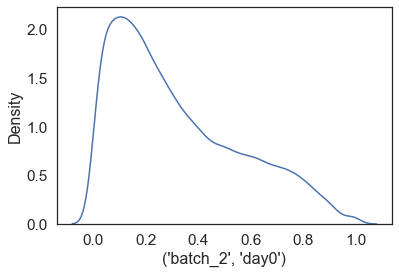

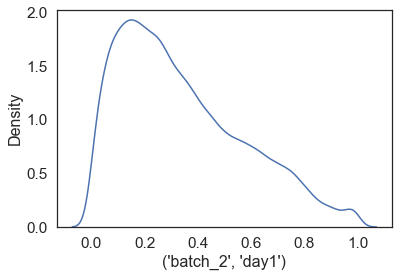

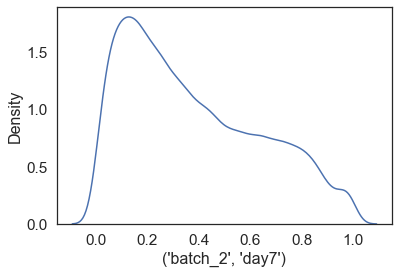

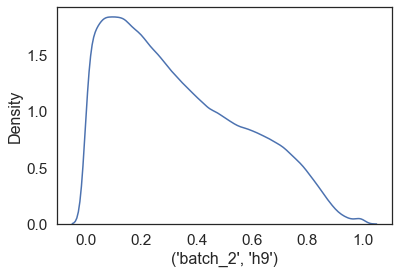

In [37]:
for col in wide_rsq_rolling_5nt.columns:
    sns.kdeplot(wide_rsq_rolling_5nt[col])
    plt.show()

0.028658656682310595 0.791118028533503
homo region 0.9603500324227157
hetero region 0.9472676082847585
homo region 0.9400648037206975
hetero region 0.9704983406291033


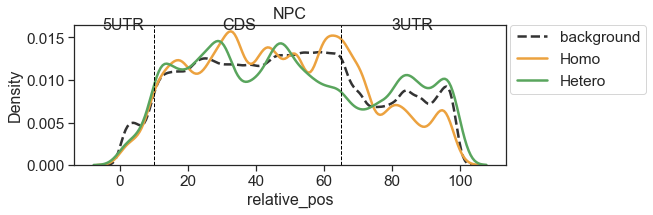

0.04182686571788727 0.7868563254229486
homo region 0.9204667651906279
hetero region 0.899418843925345
homo region 0.9065667171640887
hetero region 0.9053315284358593


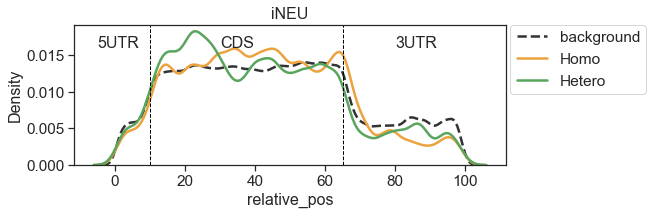

0.04424542504482501 0.8607630696309648
homo region 0.8418159011429924
hetero region 0.9706181530345481
homo region 0.8207081412320698
hetero region 0.9984634622567047


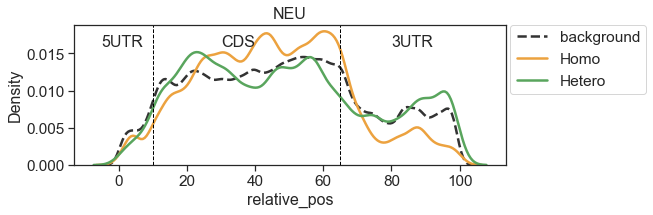

0.027001882939479614 0.7726394753300428
homo region 0.9771964758848977
hetero region 0.9650984230689753
homo region 0.9743700962506688
hetero region 0.9717185475771234


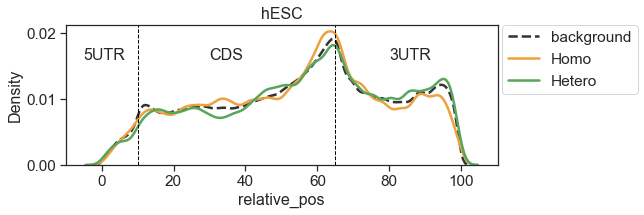

In [63]:
#temp_df = wide_rsq_df.dropna().stack([0,1]).to_frame('rsq').reset_index()
temp_df = wide_rsq_rolling_5nt.stack([0,1]).to_frame('rsq').reset_index()
#temp_df = wide_rsq_df.stack([0,1]).to_frame('rsq').reset_index()
temp_df = temp_df.loc[temp_df['rsq']>0]
#for (batch, stage), subset in temp_df.groupby(['batch','stage']):
for stage, subset in temp_df.groupby(['stage']):
    
    subset = subset.loc[subset['biotype']=="coding"]
    
    down_threshold = np.quantile(subset['rsq'], 0.05)
    up_threshold = np.quantile(subset['rsq'], 0.95)
    print (down_threshold, up_threshold)
    
    homo_subset = subset.loc[subset['rsq']>up_threshold]
    hetero_subset = subset.loc[subset['rsq']<down_threshold]
    
    #print (stats.chisquare(homo_subset['region'].value_counts(normalize=True).sort_index(), 
    #                       subset['region'].value_counts(normalize=True).sort_index()))
    #print (stats.chisquare(hetero_subset['region'].value_counts(normalize=True).sort_index(), 
    #                       subset['region'].value_counts(normalize=True).sort_index()))
    def region_enrichment_fisher_test(subset, homo_subset, hetero_subset):
        total_counts = subset['region'].value_counts(normalize=False).sort_index()
        homo_counts = homo_subset['region'].value_counts(normalize=False).sort_index()
        hetero_counts = hetero_subset['region'].value_counts(normalize=False).sort_index()
        for region in ['3utr','cds']:
            total_region_num = total_counts[region]
            homo_region_num = homo_counts[region]
            homo_not_region_num = homo_counts.sum() - homo_region_num
            nothomo_counts = total_counts - homo_counts
            nothomo_region_num = nothomo_counts[region]
            nothomo_not_region_num = nothomo_counts.sum() - nothomo_region_num
            s, p = stats.fisher_exact([[homo_region_num, homo_not_region_num],[nothomo_region_num, nothomo_not_region_num]], alternative="two-sided")
            print (region, "homo", p)
            
            
            hetero_region_num = hetero_counts[region]
            hetero_not_region_num = hetero_counts.sum() - hetero_region_num
            nothetero_counts = total_counts - hetero_counts
            nothetero_region_num = nothetero_counts[region]
            nothetero_not_region_num = nothetero_counts.sum() - nothetero_region_num
            s, p = stats.fisher_exact([[hetero_region_num, hetero_not_region_num],[nothetero_region_num, nothetero_not_region_num]], alternative="two-sided")
            print (region, "hetero", p)
    def region_enrichment_chisq_test(subset, homo_subset, hetero_subset):
        total_pct = subset['region'].value_counts(normalize=True).sort_index()
        homo_pct = homo_subset['region'].value_counts(normalize=True).sort_index()
        hetero_pct = hetero_subset['region'].value_counts(normalize=True).sort_index()
        for region in ['3utr','cds']:
            total_region_pct = total_pct[region]
            total_notregion_pct = total_pct.sum() - total_region_pct
            homo_region_pct = homo_pct[region]
            homo_notregion_pct = homo_pct.sum() - homo_region_pct
            hetero_region_pct = hetero_pct[region]
            hetero_notregion_pct = hetero_pct.sum() - hetero_region_pct
            s,p = stats.chisquare([homo_region_pct, homo_notregion_pct], [total_region_pct, total_notregion_pct])
            print ("homo",'region', p)
            s, p = stats.chisquare([hetero_region_pct, hetero_notregion_pct], [total_region_pct, total_notregion_pct])
            print ("hetero",'region', p)
   
    region_enrichment_chisq_test(subset, homo_subset, hetero_subset)       
            
    
    
    fig, ax = plt.subplots(1,1, figsize=(12,3))
    sns.set(rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16},style="white", font_scale = 1.4) ##'figure.figsize':(11.7,8.27),
    sns.set_style(style='white')
    sns.kdeplot(data=subset, x="relative_pos", common_norm=False, label="background", ax=ax, bw_adjust=0.5, lw=2.5, color="black", ls="--", alpha=0.8)
    sns.kdeplot(data=homo_subset, x="relative_pos", common_norm=False, label="Homo", ax=ax, bw_adjust=0.5, lw=2.5, color="#eca23fff")
    sns.kdeplot(data=hetero_subset, x="relative_pos", common_norm=False, label="Hetero", ax=ax, bw_adjust=0.5, lw=2.5, color="#59a55dff")
    ax.axvline(x=10, lw=1, ls="--", color="black")
    ax.axvline(x=65, lw=1, ls="--", color="black")
    
    """ax.text(x=min(ax.get_xticks())+(max(ax.get_xticks())-min(ax.get_xticks()))/10, 
            y=max(ax.get_yticks())-(max(ax.get_yticks())-min(ax.get_yticks()))/3, 
            s="5UTR", fontdict={'size':16})"""
    ax.text(x=-5, y=0.016, s="5UTR", fontdict={'size':16})
    ax.text(x=30, y=0.016, s="CDS", fontdict={'size':16})
    ax.text(x=80, y=0.016, s="3UTR", fontdict={'size':16})
    
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_position([0.2, 0.2, 0.5, 0.65])
    
    #ax.axvspan(xmin=10, xmax=15, color="#F1D395", alpha=0.5)
    #ax.axvspan(xmin=92, xmax=98, color="#F1D395", alpha=0.5)
    #ax.axvspan(xmin=40, xmax=64, color="#547A56", alpha=0.1)
    #ax.axvspan(xmin=66, xmax=70, color="#F1D395", alpha=0.5)
    
    
    
    #plt.legend(loc="upper right")
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., ncol=1)
    
    #plt.title(batch+"_"+stage)
    plt.title({'h9':'hESC',"day0":'NPC','day1':'iNEU','day7':'NEU'}[stage])
    #plt.savefig("../Results/02.Heterogeneity/Rsq.metagene.distribution.{}.homo.png".format(stage), dpi=400)
    plt.show()

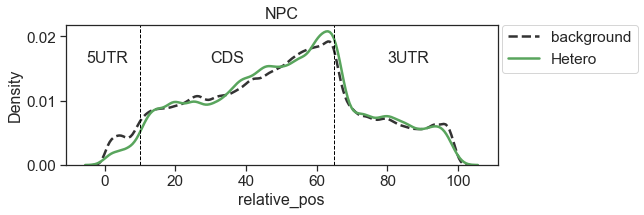

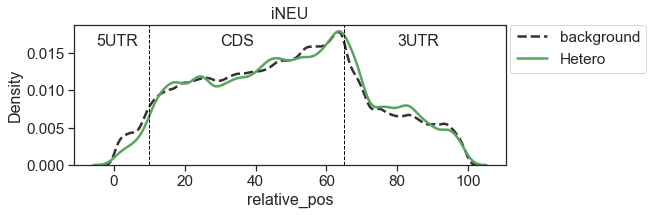

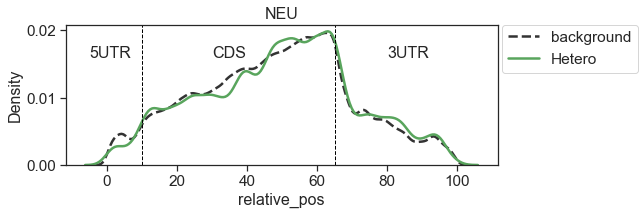

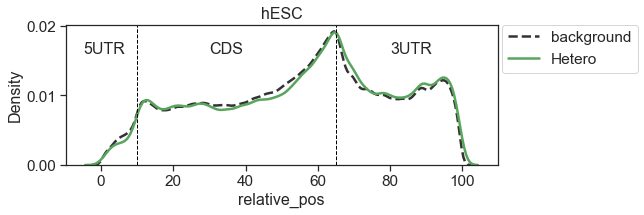

In [7]:
#temp_df = wide_rsq_df.dropna().stack([0,1]).to_frame('rsq').reset_index()
wide_rsq_df = load_large_dataFrame("../Data/04.heterogeneity_dataframe/rsq.wide_matrix.Mut_vs_Cov.genome.1nt.annot.csv", header=[0,1], index_col=[0,1,2,3,4,5,6,7,8])
temp_df = wide_rsq_df.stack([0,1]).to_frame('rsq').reset_index()
temp_df = temp_df.loc[temp_df['rsq']>0]
#for (batch, stage), subset in temp_df.groupby(['batch','stage']):
for stage, subset in temp_df.groupby(['stage']):
    
    subset = subset.loc[subset['biotype']=="coding"]
    homo_subset = subset.loc[subset['rsq']>0.75]
    hetero_subset = subset.loc[subset['rsq']<0.002]
    
    fig, ax = plt.subplots(1,1, figsize=(12,3))
    sns.set(rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16},style="white", font_scale = 1.4) ##'figure.figsize':(11.7,8.27),
    sns.set_style(style='white')
    sns.kdeplot(data=subset, x="relative_pos", common_norm=False, label="background", ax=ax, bw_adjust=0.5, lw=2.5, color="black", ls="--", alpha=0.8)
    #sns.kdeplot(data=homo_subset, x="relative_pos", common_norm=False, label="Homo", ax=ax, bw_adjust=0.5, lw=2.5, color="#eca23fff")
    sns.kdeplot(data=hetero_subset, x="relative_pos", common_norm=False, label="Hetero", ax=ax, bw_adjust=0.5, lw=2.5, color="#59a55dff")
    ax.axvline(x=10, lw=1, ls="--", color="black")
    ax.axvline(x=65, lw=1, ls="--", color="black")
    
    """ax.text(x=min(ax.get_xticks())+(max(ax.get_xticks())-min(ax.get_xticks()))/10, 
            y=max(ax.get_yticks())-(max(ax.get_yticks())-min(ax.get_yticks()))/3, 
            s="5UTR", fontdict={'size':16})"""
    ax.text(x=-5, y=0.016, s="5UTR", fontdict={'size':16})
    ax.text(x=30, y=0.016, s="CDS", fontdict={'size':16})
    ax.text(x=80, y=0.016, s="3UTR", fontdict={'size':16})
    
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_position([0.2, 0.2, 0.5, 0.65])
    
    #ax.axvspan(xmin=10, xmax=15, color="#F1D395", alpha=0.5)
    #ax.axvspan(xmin=92, xmax=98, color="#F1D395", alpha=0.5)
    #ax.axvspan(xmin=40, xmax=64, color="#547A56", alpha=0.1)
    #ax.axvspan(xmin=66, xmax=70, color="#F1D395", alpha=0.5)
    
    
    
    #plt.legend(loc="upper right")
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., ncol=1)
    
    #plt.title(batch+"_"+stage)
    plt.title({'h9':'hESC',"day0":'NPC','day1':'iNEU','day7':'NEU'}[stage])
    #plt.savefig("../Results/02.Heterogeneity/Rsq.metagene.distribution.{}.homo.png".format(stage), dpi=400)
    plt.show()

## 3.Coverage vs Rsquare

### 3.1 Coverage vs Rsquare in 10 nt

In [9]:
long_rsq_df = load_large_dataFrame("../Data/04.heterogeneity_dataframe/rsq.Mut_vs_Cov.genome.10nt.stage.csv", header=[0], index_col=[0,1])
long_rsq_df['rsq'] = np.power(long_rsq_df['r'], 2)
wide_rsq_df = long_rsq_df.reset_index().pivot(index=['gene','pos'], columns=['stage'], values='rsq')
wide_rsq_df

stage                 day0      day1      day7        h9
gene        pos                                         
AARS1       3160       NaN       NaN       NaN  0.056084
            3170       NaN       NaN       NaN  0.350402
            3180       NaN       NaN       NaN  0.514118
            3190       NaN       NaN       NaN  0.718837
            3200       NaN       NaN       NaN  0.322359
...                    ...       ...       ...       ...
human_small 1820  0.030697  0.001031  0.143579  0.018158
            1830  0.232841  0.285384  0.320444  0.098702
            1840  0.138200  0.011382  0.196235  0.333684
            1850  0.057112  0.189784  0.239388  0.335851
            1860  0.471151  0.470191  0.065084  0.517883

[56069 rows x 4 columns]

In [18]:
b1_h9_coverage_df = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/batch_1.h9.coverage.10nt.csv", index_col=[0,1], header=[0,1,2,3, 4])
b2_h9_coverage_df = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/batch_2.h9.coverage.10nt.csv", index_col=[0,1], header=[0,1,2,3, 4])
def calculate_average_coverage (coverage_df, stage="h9"):
    coverage_df = coverage_df.xs('nai-n3', level="agent", axis=1)
    coverage_df = coverage_df.groupby(level=['batch','stage'], axis=1).mean()
    return coverage_df
b1_h9_coverage_df = calculate_average_coverage(b1_h9_coverage_df)
b2_h9_coverage_df = calculate_average_coverage(b2_h9_coverage_df)
h9_coverage_df = pd.concat([b1_h9_coverage_df, b2_h9_coverage_df], axis=1)
h9_coverage_df = h9_coverage_df.groupby(level="stage", axis=1).mean()
h9_coverage_df['h9'] = np.log10(h9_coverage_df['h9']+1)
h9_coverage_df

stage            h9
gene pos           
A1BG 1520  3.375735
     1530  3.384602
     1540  3.395918
     1550  3.402433
     1560  3.410177
...             ...
ZYX  1900  3.174743
     1910  3.183298
     1920  3.195182
     1930  3.228809
     1940  3.265884

[88474 rows x 1 columns]

rsq       cov
gene        pos                     
AARS1       3160  0.056084  3.769648
            3170  0.350402  3.770902
            3180  0.514118  3.774593
            3190  0.718837  3.765458
            3200  0.322359  3.747230
...                    ...       ...
human_small 1820  0.018158  4.300254
            1830  0.098702  4.260625
            1840  0.333684  4.184840
            1850  0.335851  4.053220
            1860  0.517883  3.879614

[55849 rows x 2 columns]

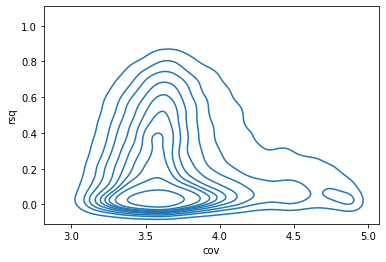

In [22]:
rsq2cov_df = pd.concat([wide_rsq_df['h9'], h9_coverage_df], axis=1)
rsq2cov_df = rsq2cov_df.dropna()
rsq2cov_df.columns = ['rsq','cov']
sns.kdeplot(data=rsq2cov_df, x="cov", y="rsq")
plt.show()
rsq2cov_df

In [26]:
slope, intercept, rvalue,pvalue, intercept_stderr = stats.linregress(rsq2cov_df['cov'], rsq2cov_df['rsq'])
print (slope, intercept, rvalue,pvalue, intercept_stderr )

-0.02606855602706163 0.3401247230653311 -0.041372290880079446 1.3555145661762526e-22 0.002664007724800189


### 3.2 Reactivity vs Rsquare in 10 nt

In [37]:
wide_reac_10nt = load_large_dataFrame("../Current_Data/03.Wide_Reac_Matrix_10nt/neural_differentiate.stages.transcripts.crude_reac.10nt.csv", header=[0,1,2,3], index_col=[0,1])
wide_reac_10nt = wide_reac_10nt.groupby(level="stage", axis=1).mean()

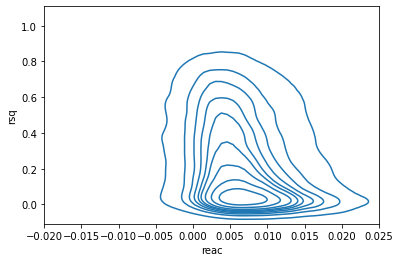

rsq      reac
gene        pos                     
AARS1       3160  0.056084  0.000760
            3170  0.350402  0.009422
            3180  0.514118  0.006138
            3190  0.718837  0.009888
            3200  0.322359 -0.008212
...                    ...       ...
human_small 1820  0.018158  0.007924
            1830  0.098702  0.004171
            1840  0.333684  0.003680
            1850  0.335851  0.008050
            1860  0.517883 -0.026552

[55440 rows x 2 columns]

In [42]:
rsq2reac_df = pd.concat([wide_rsq_df['h9'], wide_reac_10nt['h9']], axis=1)
rsq2reac_df = rsq2reac_df.dropna()
rsq2reac_df.columns = ['rsq','reac']
sns.kdeplot(data=rsq2reac_df, x="reac", y="rsq")
plt.xlim(-0.02, 0.025)
plt.show()
rsq2reac_df

In [41]:
slope, intercept, rvalue,pvalue, intercept_stderr = stats.linregress(rsq2reac_df['reac'], rsq2reac_df['rsq'])
print (slope, intercept, rvalue, pvalue, intercept_stderr )

-9.303713155893687 0.30479354402108716 -0.21977782593522838 0.0 0.17539538967180068


## Previous Data

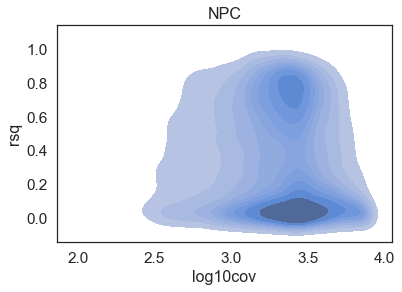

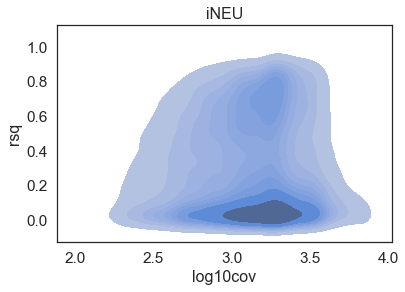

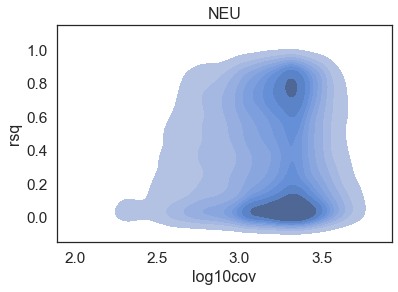

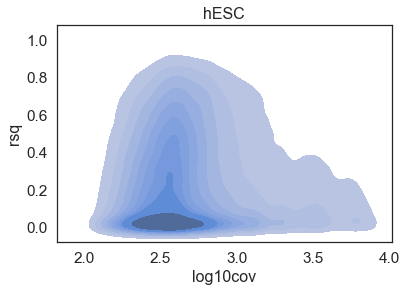

In [23]:
for col in wide_avg_coverage_df.columns:
    batch, stage = col
    if batch == "batch_2":
        continue
    rsq_series = wide_rsq_df[col].to_frame()
    rsq_series.columns = ['rsq']
    rsq_series = rsq_series.reset_index().set_index(['gene','pos'])
    cov_series = wide_avg_coverage_df[col].to_frame()
    cov_series.columns = ['coverage']
    rsq2cov_df = pd.concat([rsq_series, cov_series], axis=1)
    rsq2cov_df = rsq2cov_df.dropna()
    rsq2cov_df['log10cov'] = np.log10(rsq2cov_df['coverage'])
    sns.kdeplot(data=rsq2cov_df, x="log10cov", y="rsq", fill=True,)
    plt.title({'h9':'hESC',"day0":'NPC','day1':'iNEU','day7':'NEU'}[stage])
    plt.show()

## 4. Rsquare vs confounders 

In [ ]:
### 4.1 

In [14]:
wide_rsq_df
idx_df = wide_rsq_df.index.to_frame()
idx_df.index = list(range(idx_df.index.size))
idx_df = idx_df.set_index(['gene','pos'])
idx_df
local_rsq_df = wide_rsq_df.copy()
local_rsq_df.index = idx_df.index
local_rsq_df

batch              batch_1                                 batch_2            \
stage                 day0      day1      day7        h9      day0      day1   
gene        pos                                                                
AARS1       3058       NaN       NaN       NaN  0.728895       NaN       NaN   
            3059       NaN       NaN       NaN  0.003001       NaN       NaN   
            3060       NaN       NaN       NaN  0.862007       NaN       NaN   
            3061       NaN       NaN       NaN  0.438248       NaN       NaN   
            3062       NaN       NaN       NaN  0.393973       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
human_small 1866  0.515769  0.700049  0.833442  0.822981  0.356102  0.525330   
            1867  0.586221  0.617221  0.741459  0.966736  0.747014  0.512077   
            1868  0.727247  0.803772  0.685847  0.912938  0.719111  0.596047   
            1869  0.743982  0.720285  0.677688  0.940725  0.693261  0.580685   
            1870  0.971789  0.995001  0.979199  0.996396  0.972004  0.960175   

batch                                 
stage                 day7        h9  
gene        pos                       
AARS1       3058       NaN  0.546097  
            3059       NaN  0.003493  
            3060       NaN  0.047360  
            3061       NaN  0.190307  
            3062       NaN  0.693062  
...                    ...       ...  
human_small 1866  0.720521  0.797704  
            1867  0.567624  0.895338  
            1868  0.594926  0.721215  
            1869  0.497781  0.734293  
            1870  0.978599  0.974076  

[597798 rows x 8 columns]

In [4]:
crude_reac = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/neural_differentiate.stages.transcripts.crude_reac.csv",
                                      header=[0,1,2,3], index_col=[0,1])
gnorm_reac = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/neural_differentiate.stages.transcripts.gnorm_reac.csv",
                                      header=[0,1,2,3], index_col=[0,1])

In [10]:
avg_crude_reac = crude_reac.groupby(level=["batch","stage"], axis=1).mean()
avg_crude_reac

batch       batch_1                          batch_2                         
stage          day0 day1      day7        h9    day0 day1      day7        h9
gene   pos                                                                   
AARS1  3160     NaN  NaN       NaN  0.011216     NaN  NaN       NaN  0.006227
       3161     NaN  NaN       NaN  0.002409     NaN  NaN       NaN -0.000499
       3162     NaN  NaN       NaN -0.002317     NaN  NaN       NaN -0.011458
       3163     NaN  NaN       NaN  0.002425     NaN  NaN       NaN  0.006206
       3164     NaN  NaN       NaN -0.002207     NaN  NaN       NaN  0.001088
...             ...  ...       ...       ...     ...  ...       ...       ...
TUBA1A 1004     NaN  NaN -0.000389       NaN     NaN  NaN  0.000771       NaN
       1005     NaN  NaN  0.000209       NaN     NaN  NaN  0.025862       NaN
       1006     NaN  NaN -0.002158       NaN     NaN  NaN  0.003170       NaN
       1664     NaN  NaN  0.098669       NaN     NaN  NaN  0.014797       NaN
       1665     NaN  NaN -0.003608       NaN     NaN  NaN  0.137904       NaN

[561187 rows x 8 columns]

In [20]:
reac2rsq = pd.concat([avg_crude_reac[[('batch_1','h9')]], local_rsq_df[[('batch_1','h9')]]], axis=1, join="inner").dropna(how="any")
reac2rsq.columns = ['crude_reac','rsq']

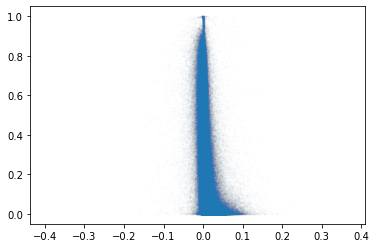

In [23]:
plt.scatter(reac2rsq['crude_reac'], reac2rsq['rsq'], s=0.5, alpha=0.01)
plt.show()

In [ ]:
rbp_motifs_db = 

In [ ]:
with open("~/scratch

## 5. Calulate Rsq of PUM2 OE/KD

In [2]:
# from Rsq_Heterogeneity import heterogeneity_by_rsquare

def calculate_Rsq_of_coverage_to_mutant(mutant_df, coverage_df):
    mutant_df = mutant_df.dropna(how="all")
    coverage_df = coverage_df.dropna(how="all")
    intersect_index = mutant_df.index.intersection(coverage_df.index)
    n = 0
    concat_list = []
    for idx in intersect_index:
        mutant_series = mutant_df.loc[idx]
        coverage_series = coverage_df.loc[idx]
        mutant_series = mutant_series.dropna()
        coverage_series = coverage_series.dropna()
        intersect_index = mutant_series.index.intersection(coverage_series.index)
        mutant_series = mutant_series.loc[intersect_index]
        coverage_series = coverage_series.loc[intersect_index]
        
        if (mutant_series.size <= 10) or (coverage_series.size <= 10):
            continue
        # print (mutant_series)
        # print (coverage_series)
        try:
            slope, intercept, r, p, stderr = stats.linregress(coverage_series, mutant_series)
        except:
            slope, intercept, r, p, stderr = np.nan, np.nan, np.nan, np.nan, np.nan
        out_series = pd.Series([slope, intercept, r, p, stderr], index=['slope','intercept','r','p','stderr'], name=idx)
        #print (out_series)
        #out_series.name = pd.MultiIndex.from_tuples(idx, names=['gene','pos'])
        concat_list.append(out_series)
        
        n += 1
        if n % 100000 == 0:
            print (n)
    out = pd.concat(concat_list, axis=1)
    out = out.T
    out.index.names = ['gene', 'pos']
    return out

def heterogeneity_by_rsquare(mutant, coverage):
    #dmso_mutant = mutant.xs('dmso', level="agent", axis=1)
    nai_mutant = mutant.xs('nai-n3', level="agent", axis=1)
    #dmso_coverage = coverage.xs('dmso', level="agent", axis=1)
    nai_coverage = coverage.xs('nai-n3', level="agent", axis=1)

    #dmso_rsquare = calculate_Rsq_of_coverage_to_mutant(dmso_mutant, dmso_coverage)
    nai_rsquare = calculate_Rsq_of_coverage_to_mutant(nai_mutant, nai_coverage)
    #return dmso_rsquare, nai_rsquare
    return nai_rsquare   

In [8]:
pum2_oe_mutant = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/pum2OE.mutant.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
pum2_oe_coverage = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/pum2OE.coverage.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])

pum2_kd_mutant = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/pum2KD.mutant.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])
pum2_kd_coverage = load_large_dataFrame("../Current_Data/01.Mutant_Rate_Matrix.10nt/pum2KD.coverage.10nt.csv", header=[0,1,2,3,4], index_col=[0,1])

In [9]:
col_df = pum2_oe_mutant.columns.to_frame()
col_df.index = list(range(col_df.index.size))
col_df[['batch','stage','agent']].value_counts().sort_index()

agent 
dmso       8
nai-n3    40
dtype: int64

In [21]:
concat_lst = []
for stage, subset in pum2_oe_mutant.groupby(level="stage", axis=1):
    subset_mutant = subset
    subset_coverage = pum2_oe_coverage.xs(stage, level="stage", axis=1, drop_level=False)
    subset_rsq = heterogeneity_by_rsquare(subset_mutant, subset_coverage)
    subset_rsq['stage'] = stage
    subset_rsq['rsq'] = np.power(subset_rsq['r'], 2)
    concat_lst.append(subset_rsq)
pum2_oe_rsq = pd.concat(concat_lst)
pum2_oe_rsq.to_csv("../Current_Data/06.Heterogeneity_by_Rsq/rsq_for_pum2oekd/pum2_oe_rsq.csv")

In [7]:
concat_lst = []
for stage, subset in pum2_kd_mutant.groupby(level="stage", axis=1):
    subset_mutant = subset
    subset_coverage = pum2_kd_coverage.xs(stage, level="stage", axis=1, drop_level=False)
    subset_rsq = heterogeneity_by_rsquare(subset_mutant, subset_coverage)
    subset_rsq['stage'] = stage
    subset_rsq['rsq'] = np.power(subset_rsq['r'], 2)
    concat_lst.append(subset_rsq)
pum2_kd_rsq = pd.concat(concat_lst)
pum2_kd_rsq
#pum2_kd_rsq.to_csv("../Current_Data/06.Heterogeneity_by_Rsq/rsq_for_pum2oekd/pum2_kd_rsq.csv")

'concat_lst = []\nfor stage, subset in pum2_kd_mutant.groupby(level="stage", axis=1):\n    subset_mutant = subset\n    subset_coverage = pum2_kd_coverage.xs(stage, level="stage", axis=1, drop_level=False)\n    subset_rsq = heterogeneity_by_rsquare(subset_mutant, subset_coverage)\n    subset_rsq[\'stage\'] = stage\n    subset_rsq[\'rsq\'] = np.power(subset_rsq[\'r\'], 2)\n    concat_lst.append(subset_rsq)\npum2_kd_rsq = pd.concat(concat_lst)\npum2_kd_rsq\npum2_kd_rsq.to_csv("../Current_Data/06.Heterogeneity_by_Rsq/rsq_for_pum2oekd/pum2_kd_rsq.csv")'

## 6. check overage of heterogeneous windows

In [9]:
## Retrieve mutrate matrix
b1_h9_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt//neural_differentiation.mutrate_data/batch_1.h9.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_h9_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.h9.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day0_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day0.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day0_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day0.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day1_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day1.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day1_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day1.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day7_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day7.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day7_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day7.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])

h9_mutrate = pd.concat([b1_h9_mutrate, b2_h9_mutrate], axis=1)
day0_mutrate = pd.concat([b1_day0_mutrate, b2_day0_mutrate], axis=1)
day1_mutrate = pd.concat([b1_day1_mutrate, b2_day1_mutrate], axis=1)
day7_mutrate = pd.concat([b1_day7_mutrate, b2_day7_mutrate], axis=1)

h9_mutrate = h9_mutrate.loc[h9_mutrate.isnull().sum(axis=1) < h9_mutrate.columns.size*0.5]
day0_mutrate = day0_mutrate.loc[day0_mutrate.isnull().sum(axis=1) < day0_mutrate.columns.size*0.5]
day1_mutrate = day1_mutrate.loc[day1_mutrate.isnull().sum(axis=1) < day1_mutrate.columns.size*0.5]
day7_mutrate = day7_mutrate.loc[day7_mutrate.isnull().sum(axis=1) < day7_mutrate.columns.size*0.5]

### add rRNAs
rRNA_df = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/all_cells.mutrate.rRNA.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
def add_rRNA_data(rRNA_df, df):
    df = df.loc[~df.index.get_level_values('gene').isin(['human_small', 'human_large'])]
    df = pd.concat([df, rRNA_df], join="inner")
    return df
h9_mutrate = add_rRNA_data(rRNA_df, h9_mutrate)
day0_mutrate = add_rRNA_data(rRNA_df, day0_mutrate)
day1_mutrate = add_rRNA_data(rRNA_df, day1_mutrate)
day7_mutrate = add_rRNA_data(rRNA_df, day7_mutrate)

mutrate_df = pd.concat([h9_mutrate, day0_mutrate, day1_mutrate, day7_mutrate], axis=1)
mutrate_df.loc[:, ~mutrate_df.columns.get_level_values('id').isin(['RHE1585', 'RHE1614','RHE1587','RHE1615','RHE1600','RHE1653','RHE1602','RHE1655','RHE1584'])]
mutrate_df = mutrate_df.xs('nai-n3', level="agent", axis=1, drop_level=False)

In [13]:
crude_reac = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/neural_differentiate.stages.transcripts.crude_reac.csv",
                                      header=[0,1,2,3], index_col=[0,1])

In [7]:
mutant_df.loc['MZT2A']  #MZT2A

id,RHE1534,RHE1540,RHE1546,RHE1552,RHE1558,RHE1564,RHE1570,RHE1576,RHE1577,RHE1578,...,RHN1702,RHN1703,RHN1704,RHN1705,RHN1706,RHN1707,RHN1708,RHN1709,RHN1710,RHN1711
batch,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,...,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2
stage,h9,h9,h9,h9,h9,h9,h9,h9,h9,h9,...,day7,day7,day7,day7,day7,day7,day7,day7,day7,day7
agent,dmso,dmso,dmso,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,...,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,dmso,dmso,dmso,dmso
lib_type,single,single,single,single,single,single,single,single,single,single,...,single,single,single,single,single,single,single,single,single,single
pos,,,,,,,,,,,,,,,,,,,,,
141,1.0,2.0,3.0,2.0,0.0,3.0,1.0,0.0,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,0.0,2.0,1.0,2.0,0.0,23.0,2.0,1.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,3.0,2.0,2.0,149.0,0.0,25.0,1.0,0.0,0.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,2.0,3.0,4.0,2.0,0.0,4.0,5.0,0.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,0.0,2.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
coverage_df.loc['MZT2A']

id,RHE1534,RHE1540,RHE1546,RHE1552,RHE1558,RHE1564,RHE1570,RHE1576,RHE1577,RHE1578,...,RHN1702,RHN1703,RHN1704,RHN1705,RHN1706,RHN1707,RHN1708,RHN1709,RHN1710,RHN1711
batch,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,...,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2
stage,h9,h9,h9,h9,h9,h9,h9,h9,h9,h9,...,day7,day7,day7,day7,day7,day7,day7,day7,day7,day7
agent,dmso,dmso,dmso,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,...,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,dmso,dmso,dmso,dmso
lib_type,single,single,single,single,single,single,single,single,single,single,...,single,single,single,single,single,single,single,single,single,single
pos,,,,,,,,,,,,,,,,,,,,,
141,101.0,92.0,203.0,259.0,97.0,305.0,148.0,90.0,118.0,246.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,101.0,92.0,203.0,258.0,93.0,304.0,148.0,90.0,118.0,246.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,101.0,92.0,203.0,259.0,93.0,306.0,148.0,90.0,118.0,244.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,103.0,93.0,209.0,259.0,92.0,300.0,148.0,91.0,113.0,244.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,103.0,93.0,209.0,260.0,91.0,299.0,148.0,91.0,113.0,237.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
mutrate_df.loc['RBM17']

id,RHE1552,RHE1558,RHE1564,RHE1570,RHE1576,RHE1577,RHE1578,RHE1579,RHE1580,RHE1581,...,RHN1698,RHN1699,RHN1700,RHN1701,RHN1702,RHN1703,RHN1704,RHN1705,RHN1706,RHN1707
batch,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,...,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2
stage,h9,h9,h9,h9,h9,h9,h9,h9,h9,h9,...,day7,day7,day7,day7,day7,day7,day7,day7,day7,day7
agent,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,...,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3,nai-n3
lib_type,single,single,single,single,single,single,single,single,single,single,...,single,single,single,single,single,single,single,single,single,single
pos,,,,,,,,,,,,,,,,,,,,,
312,0.016055,0.028443,0.037773,0.035514,0.031915,NaN,0.026565,NaN,0.031250,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,0.018349,0.000000,0.003984,0.013183,0.015873,NaN,0.001883,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314,0.477958,0.032353,0.000000,0.009381,0.010526,NaN,0.011152,NaN,0.015748,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315,0.033333,0.005908,0.001992,0.001873,0.005208,NaN,0.009276,NaN,0.000000,0.016760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316,0.000000,0.000000,0.001980,0.000000,0.005102,NaN,0.014545,NaN,0.000000,0.005495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
crude_reac.loc['ARPC5L'].xs('h9', level="stage", axis=1).mean(axis=1).describe()

count    145.000000
mean       0.007451
std        0.018503
min       -0.076716
25%       -0.001634
50%        0.002320
75%        0.013911
max        0.084802
dtype: float64